# High Throughput Growth Experiment Analysis in Biotechnology
***

## Background
Biotechnology requires knowledge of microbial physiology and metabolism. Among the most important information is the growth rate and the substrate uptake rate. Both can be used to calculate the effectiveness of biotechnological production strategies and biomass and product yields. To identify an organism with suitable growth parameters, multiple strains, mutants or environmental conditions are tested which results in high throughput data. To analyse high throughput data computational approaches can speed up the process.

There are different growth phenotypes: exponential, linear, saturated, diauxie. The typical microbial saturated growth is divided in different growth phases, lag, log, stationary, and death phase.

Laws to describe a biomass $N$ include: 
- exponential law: $N(t) = N_0e^{\mu t}$
  - $N_0$: initial biomass, gDW/L
  - $\mu$: growth rate, /h
  - $t$: duration, h
- logistic growth law (Verhulst): $N(t) = \frac{K}{1+\left( \frac{K-N_0}{N_0}e^{-\mu t} \right)}$
  - $N_0$: initial biomass, gDW/L
  - $\mu$: growth rate, /h
  - $t$: duration, h
  - $K$: carrying capacity, max biomass, gDW/L
- Gompertz function: $N(t) = N_0e^{\left(\textrm{ln} \left(\frac{K}{N_0} \right)\left(1 - e^{-\mu t} \right) \right)}$
  - $N_0$: initial biomass, gDW/L
  - $\mu$: growth rate, /h
  - $t$: duration, h
  - $K$: carrying capacity, max biomass, gDW/L
- Baranyi model: complex model, see [literature](https://doi.org/10.1006/fmic.1999.0285)

## Objective
1. Determine the optimal growth temperature
2. Calculate the growth rate and substrate uptake rate at different substrate concentrations
3. Evaluate the growth yields

### Additional information:
- Hagen, Exponential growth of bacteria: Constant multiplication through division, American Journal of Physics, 2010. doi [10.1119/1.3483278](https://doi.org/10.1119/1.3483278)
- Verduyn et al., A theoretical evaluation of growth yields of yeasts, Antoie van Leeuwenhoek, 1991. doi [10.1007/BF00582119](https://doi.org/10.1007/BF00582119)
- Pirt, The maintenance energy of bacteria in growing cultures, 1965. doi [10.1098/rspb.1965.0069](https://doi.org/10.1098/rspb.1965.0069)

## Workflow

**1 Set-up of simulation environment**
 * *1.1 Loading Python libraries and functions*
 * *1.2 Seeding your individual organism*

**2 High Throughput Temperature measurements**
 * *2.1 96-well plate experiment simulation* 
 * *2.2 Python based data analysis*
 * *2.3 Data export to Excel*
 
**3 Substrate uptake rates**
 * *3.1 Experiment setup (temperature, substrate concentrations, duration)*
 * *3.2 Data analysis*
 * *3.3 Data export to Excel* 

**4 Yield calculations**
 * *4.1 Yield formula*
 * *4.2 Assessment against published yields*

**5 Evaluation by peer review**
 * *5.1 Report of results*
 * *5.2 Peer review*

In [2]:
# Loading of important functionalities for the notebook:
# Loading numpy, a library fo manipulation of numbers:
import os
import numpy as np
# Loading matplotlib, a library for visualization:
import matplotlib.pyplot as plt
# Initialization, loading of all laboratory functionalities and stored models and information of the organisms:
from FermProSimFun import MonodModel as Model

from silvio.catalog.RecExpSim import RecExperiment, combine_data
from silvio.extensions.records.gene.crafted_gene import CraftedGene

from silvio.catalog.GroExpSim import *# GrowthExperiment

print('System ready')

System ready


In [3]:
exp = GrowthExperiment(161710, 2000, 10000)

In [4]:
host = exp.create_host('ecol')
exp.print_status()
vars(host.growth)

Experiment:
  budget = 8000
  failure rate = 0.12
  hosts = [ ecol ]


{'opt_growth_temp': 28,
 'max_biomass': 31,
 'Ks': 7.521,
 'Yxs': 0.47,
 'k1': 0.156,
 'umax': 0.716,
 'make_generator': <bound method Host.make_generator of <silvio.catalog.GroExpSim.GroHost object at 0x7fbf76668910>>}

Data exported to: /home/ulf/Documents/2109_BLS+SILVIO/biolabsim_dev/ExperimentGrowthSubstrateRate.csv
Experiment:
  budget = 6038
  failure rate = 0.12
  hosts = [ ecol ]


/home/ulf/Documents/2109_BLS+SILVIO/silvio/src/silvio/catalog/GroExpSim.py:233: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for Exp,X in Biomass.iteritems(): # LnBiomass.iteritems(), Biomass.iteritems()


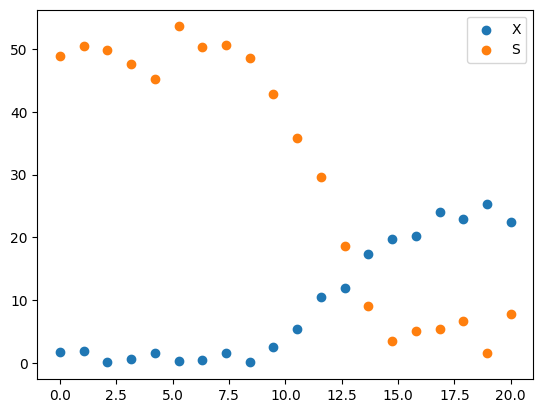

In [23]:
exp.simulate_monod('ecol', 35,[20,20],[50],test='Monod')
exp.print_status()

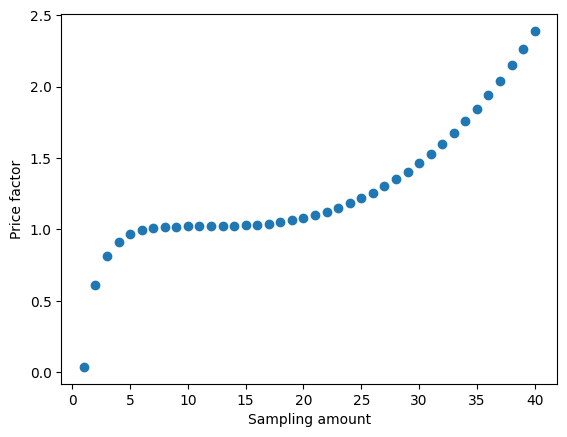

2.388791244054826

In [6]:
calculate_ExpPriceFactor(40, True)

In [ ]:
myMod = Model()
# myMod.__str__()
myMod.calculate_monod()
myMod.plot_results()

"Monod_Model instance for a E. coli-batch microbial production process. \nCurrent parameters: {'u0': 0, 'umax': 0.788, 'duration': 24, 'Ks': 9.04, 'Yx': 0.407, 'k1': 0.114}"

In [1]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt

def MonodEqnODE(MonodVars, t, mumax, Ks, Yxs):
    """
    Monod bioprocess model with ODEs.
    Based on the model described in:
    Hemmerich et al., doi:10.1002/elsc.202000088, Fig. 6
    """
    # Unpack y and z
    X, S = MonodVars

    # Compute biomass growth rate
    dX_dt = mumax * S * X / (Ks + S)

    # Compute substrate consumption rate
    dS_dt = -mumax * S * X / (Ks + S) / Yxs

    # Return the result as a NumPy array
    return np.array([dX_dt, dS_dt])

def solve_MonodEqn(Params, Initials, t):
    """
    Solve the Monod bioprocess model with ODEs.
    Based on the model described in:
    Hemmerich et al., doi:10.1002/elsc.202000088, Fig. 6
    """
    # Unpack parameters
    mumax, Ks, Yxs = Params['mumax'], Params['Ks'], Params['Yxs']
    # Initial condition
    MonodVars_0 = [Initials['X0'], Initials['S0']]

    # Parameters
    args = (mumax, Ks, Yxs)

    # Integrate ODES
    MonodSol = spi.odeint(MonodEqnODE, MonodVars_0, t, args=args)

    # Return the result as a NumPy array
    return MonodSol

def add_noise(data, noise):
    """
    Add noise to data.
    """
    # Each column get a different noise based on the average value of the column
    noise = noise * np.mean(data, axis=0)  
    return data + np.random.normal(0, noise, data.shape)

In [6]:
import pandas as pd
round(pd.DataFrame(MonodSol, columns=['X', 'S']), 2)


,X,S
0,0.01,10.00
1,0.02,9.97
2,0.05,9.91
3,0.10,9.78
4,0.20,9.52
5,0.42,8.97
6,0.85,7.89
7,1.62,5.97
8,2.70,3.28
9,3.59,1.04


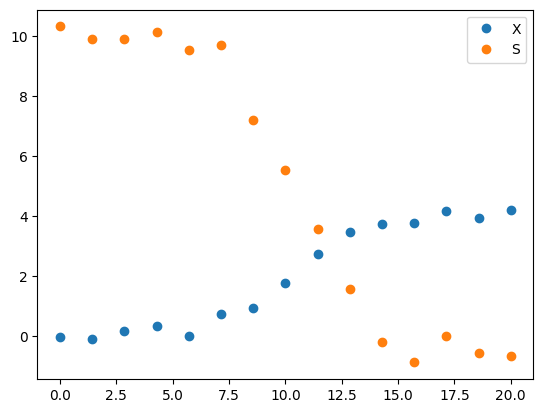

In [3]:
Params={'mumax': 0.9, 'Ks': 7, 'Yxs': .4}
Initials={'X0': 0.01, 'S0': 10}
t=np.linspace(0, 20, 15)
MonodSol = solve_MonodEqn(Params, Initials, t)
plt.plot(t, add_noise(MonodSol,.1), label=['X', 'S'], marker='o', linestyle='None')
plt.legend()

In [ ]:
def OD2X(OD, OD0, X0):
    """
    Convert OD to biomass concentration.
    """
    return X0 * OD / OD0
def X2OD(X, OD0, X0):
    """
    Convert biomass concentration to OD.
    """
    return OD0 * X / X0